In [1]:
#Importações das bibliotecas para manipulação, tratamento e visualização dos dados
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Importações de modelos de ML e tratamento de dados
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)
from joblib import dump

#Importações de funções e variáveis criadas
from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import(
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,bedrooms_per_room,rooms_per_households,population_per_households
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,0.146591,6.984127,2.555556
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,0.155797,6.238137,2.109842
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,0.260274,4.294117,2.026891
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,0.252679,4.242424,2.640152
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,0.203216,5.343676,2.362768


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   longitude                  17564 non-null  float32 
 1   latitude                   17564 non-null  float32 
 2   housing_median_age         17564 non-null  int8    
 3   total_rooms                17564 non-null  int16   
 4   total_bedrooms             17564 non-null  int16   
 5   population                 17564 non-null  int16   
 6   households                 17564 non-null  int16   
 7   median_income              17564 non-null  float32 
 8   median_house_value         17564 non-null  int32   
 9   ocean_proximity            17564 non-null  category
 10  median_income_cat          17564 non-null  int64   
 11  bedrooms_per_room          17564 non-null  float32 
 12  rooms_per_households       17564 non-null  float32 
 13  population_per_households  1756

In [4]:
coluna_target = ['median_house_value']
coluna_one_hot_encoder = ['ocean_proximity']
coluna_ordinal_encoder = ['median_income_cat']

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_households',
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

In [9]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


c:\Users\Samuel\anaconda3\envs\machine_learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 20.0}

In [12]:
grid_search.best_score_

np.float64(-50449.08651760808)

In [13]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-0.878944
robust_scaler_poly__latitude,-0.779364
one_hot__ocean_proximity_INLAND,-0.491589
robust_scaler_poly__population_per_households,-0.333652
robust_scaler_poly__latitude^2,-0.292633
...,...
robust_scaler_poly__housing_median_age longitude^2,0.192502
robust_scaler_poly__latitude median_income population_per_households,0.220310
robust_scaler_poly__housing_median_age median_income,0.247997
robust_scaler_poly__bedrooms_per_room,0.317573


In [14]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.001997,0.003001,-0.000081,-77516.042766,-96239.705692,0.004998
1,DummyRegressor,0.002003,0.001998,-0.000146,-75787.787194,-95217.629397,0.004001
2,DummyRegressor,0.002002,0.002999,-0.001737,-76753.598961,-96253.253947,0.005
3,DummyRegressor,0.001001,0.003,-0.000101,-76837.804811,-95983.885799,0.004001
4,DummyRegressor,0.002001,0.001999,-0.000114,-76617.245449,-96182.764729,0.004
5,LinearRegression,0.038996,0.008001,0.682162,-39855.690996,-54254.958188,0.046997
6,LinearRegression,0.017997,0.006,0.66999,-40272.565467,-54695.230283,0.023998
7,LinearRegression,0.018,0.006,0.649247,-42178.05929,-56955.988706,0.024
8,LinearRegression,0.017,0.006001,0.669873,-40806.492497,-55146.318803,0.023002
9,LinearRegression,0.019001,0.007,0.669023,-40788.496497,-55331.35106,0.026


In [15]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001801,0.002599,-0.000436,-76702.495836,-95975.447913,0.0044
LinearRegression,0.022199,0.0066,0.668059,-40780.26095,-55276.769408,0.028799
LinearRegression_grid_search,0.100458,0.0156,0.723281,-35364.315084,-50457.776631,0.116058
LinearRegression_target,0.0244,0.0072,0.678168,-38674.926548,-54424.649052,0.031601


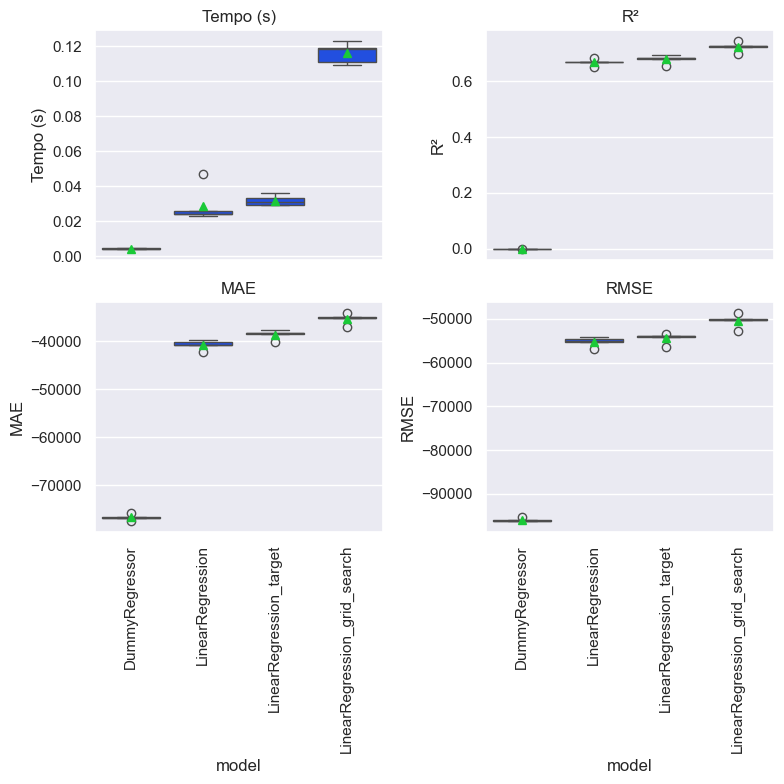

In [16]:
plot_comparar_metricas_modelos(df_resultados)

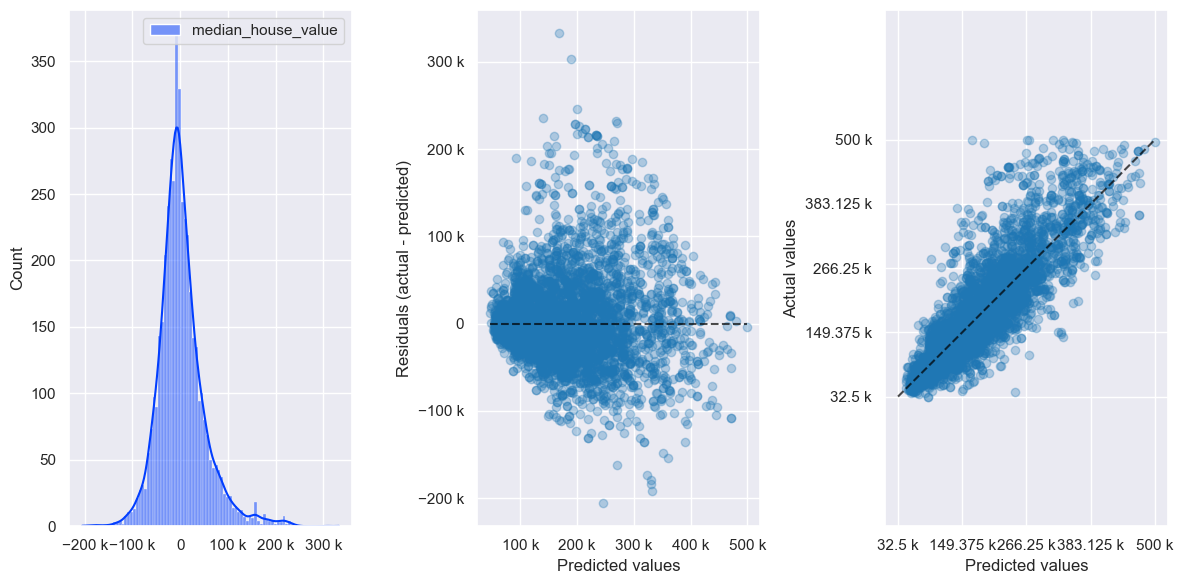

In [17]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True)

In [18]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\Samuel\\Desktop\\Portfólio Python\\Machine Learning\\02_house_prices\\modelos\\ridge_polyfeat_target_quantile.joblib']